The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Plotting calibration of ISIC2016+ISIC2017+ISIC2018+MEDNODE+KaggleMB_ResNet50_metrics_reject model
Plotting ISIC2017 testset
Plotting ISIC2018 testset
Plotting KaggleMB testset
Plotting _7_point_criteria testset
Plotting ISIC2017 testset
Plotting ISIC2018 testset
Plotting KaggleMB testset
Plotting _7_point_criteria testset
Plotting calibration of ISIC2020_ResNet50_metrics_reject model
Plotting ISIC2017 testset
Plotting ISIC2018 testset
Plotting KaggleMB testset
Plotting _7_point_criteria testset
Plotting ISIC2017 testset
Plotting ISIC2018 testset
Plotting KaggleMB testset
Plotting _7_point_criteria testset


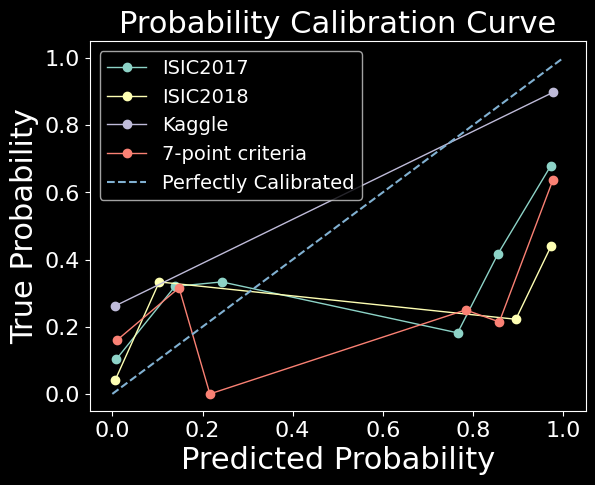

In [5]:
import os
import pathlib
import itertools
import glob
import melanoma as mel
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
%matplotlib inline
%load_ext autoreload
%autoreload -p 2

snapshot_path = os.path.join(pathlib.Path.cwd(), 'snapshot')

jsonfiles = list(itertools.chain.from_iterable([glob.glob(f'{snapshot_path}/ResNet50/performance/*_*_metrics_reject.json', recursive=True)]))
jsonnames = list(map(lambda x: pathlib.Path(os.path.basename(x)).stem, jsonfiles))
jsonpaths = list(map(lambda x: pathlib.Path(os.path.dirname(x)), jsonfiles))

# plt.ioff()
plt.style.use(['dark_background'])

DBtypes = [db.name for db in mel.DatasetType]



for idx, j in enumerate(jsonfiles):
    plt.clf()
    print(f'Plotting calibration of {jsonnames[idx]} model')
    fi = open(j)
    jfile = json.load(fi)


    if not os.path.exists(os.path.join(jsonpaths[idx], 'calib_plots')):
        os.makedirs(os.path.join(jsonpaths[idx], 'calib_plots'), exist_ok=True)

    classifier_name = pathlib.Path(jsonpaths[idx]).parent.stem
    used_DB_list = [each_model for each_model in DBtypes if(each_model in jsonnames[idx])]
    DBnames = '+'.join(used_DB_list)

    

    for reject_status in ['before_reject', 'after_reject']:
        plt.clf()
        y_position = 0.03  # Starting position (at the bottom)
        y_step = 0.03  # Step size for each new line
        
        for db in ('ISIC2017', 'ISIC2018', 'KaggleMB', '_7_point_criteria'):
            print(f"Plotting {db} testset")
            if reject_status == 'before_reject':
                scores_all = np.array(jfile[db]['y_scores'])
                labels_all = np.array(jfile[db]['y_labels'])
            elif reject_status == 'after_reject':
                scores_all = np.array(jfile[db]['Non-rejected']['y_scores'])
                labels_all = np.array(jfile[db]['Non-rejected']['y_labels'])
            # preds_all = np.array(jfile[db]['y_pred'])
            # ids_all = np.array(jfile[db]['y_ids'])

            # Probability estimate
            prob_pos = scores_all[:, 1]
            
            # Brier Score
            b_score = brier_score_loss(labels_all, prob_pos)
            # print("Brier Score :",b_score)
            # ECE
            ece = mel.Model.expected_calibration_error(scores_all, labels_all, M=10)
            # print("ECE: ", ece)
            
            # True and Predicted Probabilities
            true_pos, pred_pos = calibration_curve(labels_all, prob_pos, n_bins=10)
            
            
            
            #Plot the Probabilities Calibrated curve

            if db == '_7_point_criteria':
                plt.plot(pred_pos,
                        true_pos, 
                        marker='o', 
                        linewidth=1, 
                        label='7-point criteria')
            elif db == 'KaggleMB':
                plt.plot(pred_pos,
                        true_pos, 
                        marker='o', 
                        linewidth=1, 
                        label='Kaggle')
            else:
                plt.plot(pred_pos,
                        true_pos, 
                        marker='o', 
                        linewidth=1, 
                        label=db)
            # if reject_status == 'after_reject':
            #     plt.figtext(0.05, -y_position, f"Threshold: {jfile[db]['Threshold']}", horizontalalignment='left', wrap=True)
            #     y_position += y_step
            # plt.figtext(0.05, -y_position, f"{db} - Brier: {b_score}, ECE: {ece}", horizontalalignment='left', wrap=True)
            # y_position += y_step
            
        #Plot the Perfectly Calibrated by Adding the 45-degree line to the plot
        plt.plot([0, 1], 
                [0, 1], 
                linestyle='--', 
                label='Perfectly Calibrated')
        
        
        # Set the title and axis labels for the plot
        plt.title('Probability Calibration Curve', fontsize=22)
        plt.xlabel('Predicted Probability', fontsize=22)
        plt.ylabel('True Probability', fontsize=22)
        

        
        
        # Add a legend to the plot
        plt.legend(loc='best', fontsize=14)

        font = {
            'family': 'sans-serif',
            'size': 9
        }

        plt.rc('font', **font)

        if reject_status == 'before_reject':
            plt.tick_params(axis='both', labelsize=16)
            plt.savefig(os.path.join(jsonpaths[idx], 'calib_plots', DBnames+'_'+classifier_name+'_calibration_beforeReject'), bbox_inches='tight')
            
            
        elif reject_status == 'after_reject':
            plt.tick_params(axis='both', labelsize=16)
            plt.savefig(os.path.join(jsonpaths[idx], 'calib_plots', DBnames+'_'+classifier_name+'_calibration_afterReject'), bbox_inches='tight')
            
            
        # plt.show()
        
        # Show the plot
    
        